In [ ]:
###############################################################
# Task : Fraud detection model for a financial company
#        and study of different models on the fraud detection.
# Created by : Shreeya Sati
# Created On : 25-03-2025
# Last Updated : 26-03-2025
# email : shreeyasati@gmail.com
# Observations : XGBoost with balanced data performs better 
#                as compared to other models.
################################################################
# Basic libraries
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")  # Ignore warnings
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
# Hyperparameter optimization
!pip install scikit-optimize
from skopt import BayesSearchCV

# Scientific and statistical libraries
from scipy import stats
from scipy.stats import norm, skew, boxcox_normmax
from scipy.special import boxcox1p

# Machine learning and preprocessing
import sklearn
from sklearn import metrics, preprocessing
from sklearn.metrics import (
    roc_curve, auc, classification_report,
    confusion_matrix, average_precision_score,
    precision_recall_curve
)
from sklearn.preprocessing import StandardScaler, PowerTransformer

# Model selection and cross-validation
from sklearn.model_selection import (
    train_test_split, StratifiedKFold,
    GridSearchCV, RandomizedSearchCV, cross_val_score
)

# Machine learning models
from sklearn.linear_model import Ridge, Lasso, LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier
)

In [3]:
data = pd.read_csv("C:/Users/pcsat/OneDrive/Desktop/Fraud.csv")
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
# Examining the dataset imported:
print(data.shape)
print(data.info())
print(data.describe())
#Check the fraud/Non_Fraud related records
data['isFraud'].value_counts()

(6362620, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [8]:
#find % values of class
(data.groupby('isFraud')['isFraud'].count()/data['isFraud'].count()) *100

isFraud
0    99.870918
1     0.129082
Name: isFraud, dtype: float64

In [9]:
#check if any null values
data.isnull().sum() 

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

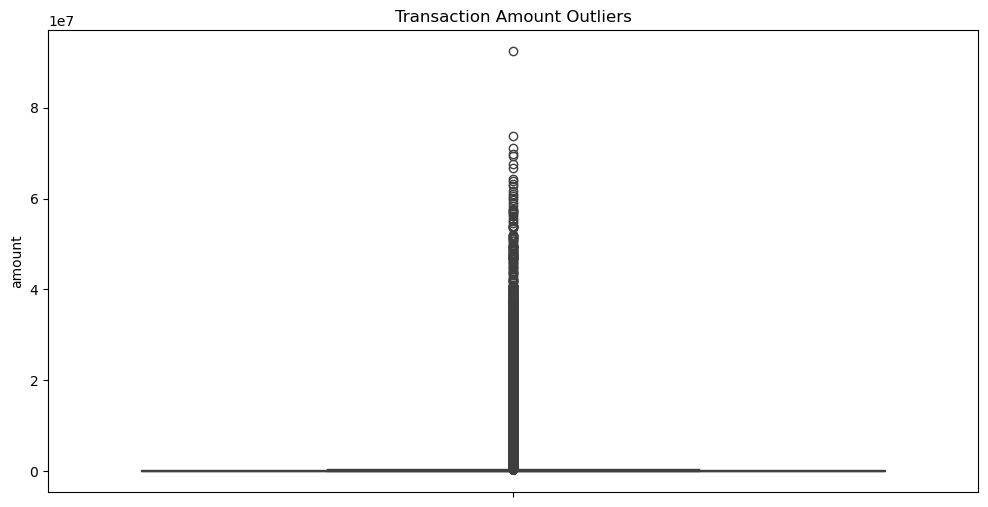

In [144]:
# Visualizing outliers in transaction amounts
plt.figure(figsize=(12, 6))
sns.boxplot(data['amount'])
plt.title('Transaction Amount Outliers')
plt.show()


<Figure size 1000x600 with 0 Axes>

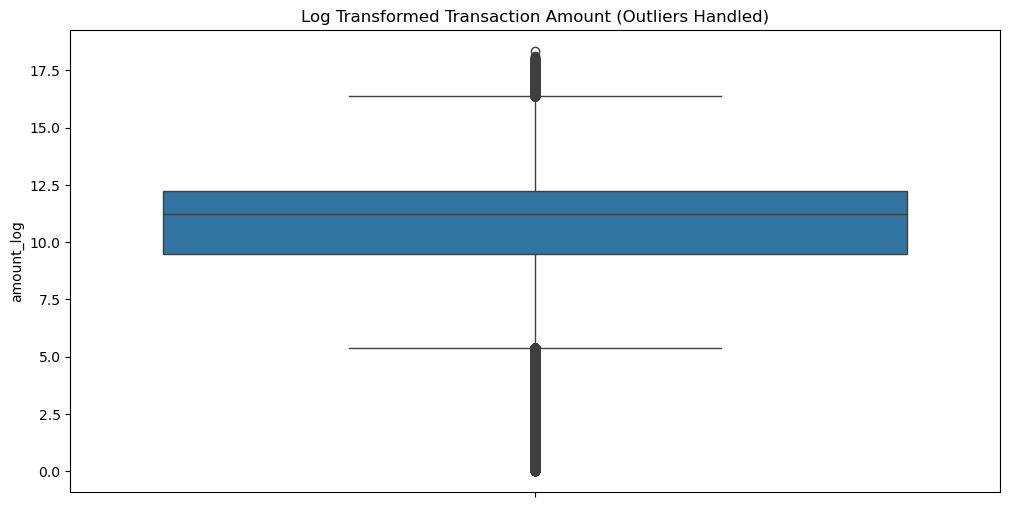

In [147]:
# Apply log transformation to compress large transaction amounts
data['amount_log'] = np.log1p(data['amount'])

# Let's quickly visualize the transformed feature
plt.figure(figsize=(12, 6))
sns.boxplot(data['amount_log'])
plt.title('Log Transformed Transaction Amount (Outliers Handled)')
plt.show()

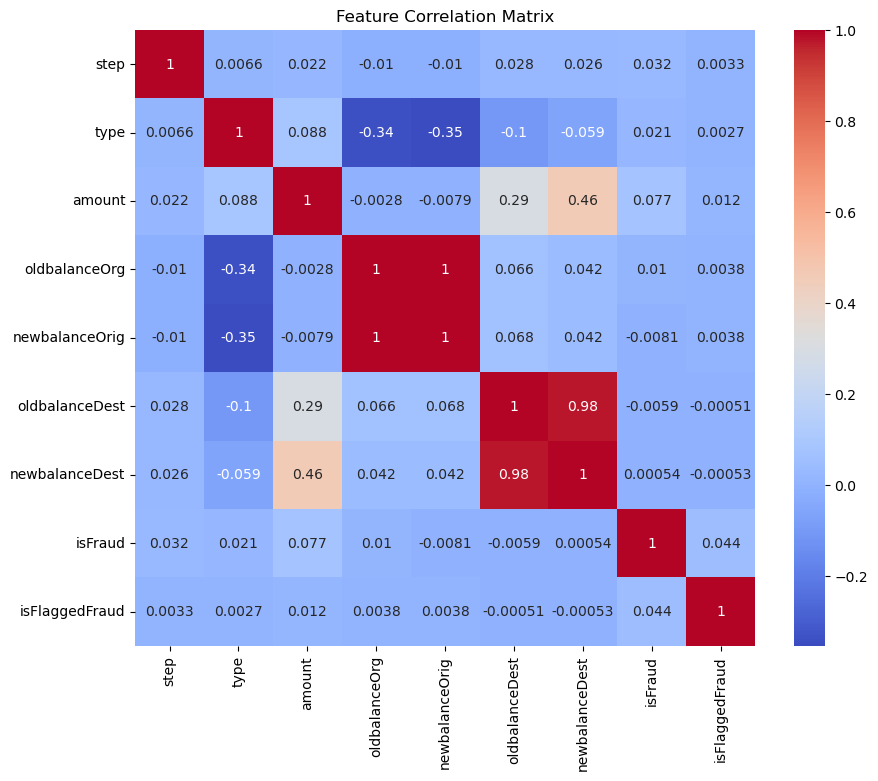

In [145]:
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

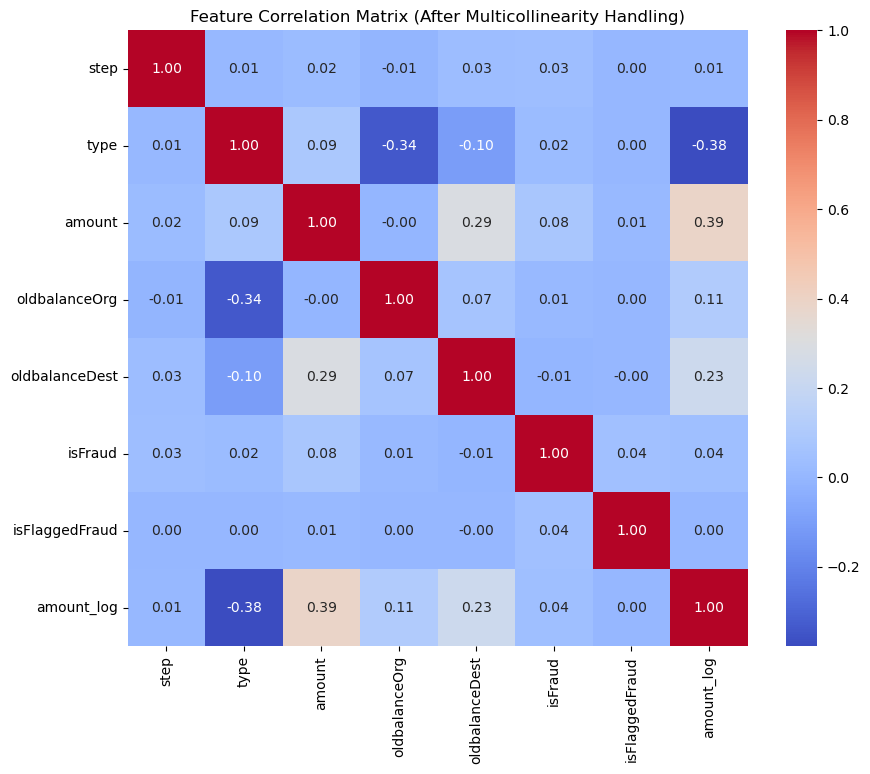

In [148]:
# Dropping one feature from each highly correlated pair
data_cleaned = data.drop(['newbalanceOrig', 'newbalanceDest'], axis=1)

# Let's re-check the correlation matrix to confirm
plt.figure(figsize=(10, 8))
sns.heatmap(data_cleaned.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix (After Multicollinearity Handling)')
plt.show()


In [ ]:
# We selected variables using a combination of statistical analysis and domain knowledge.
# First, I analyzed a correlation heatmap to detect multicollinearity and dropped highly correlated features
# to avoid redundancy and overfitting.

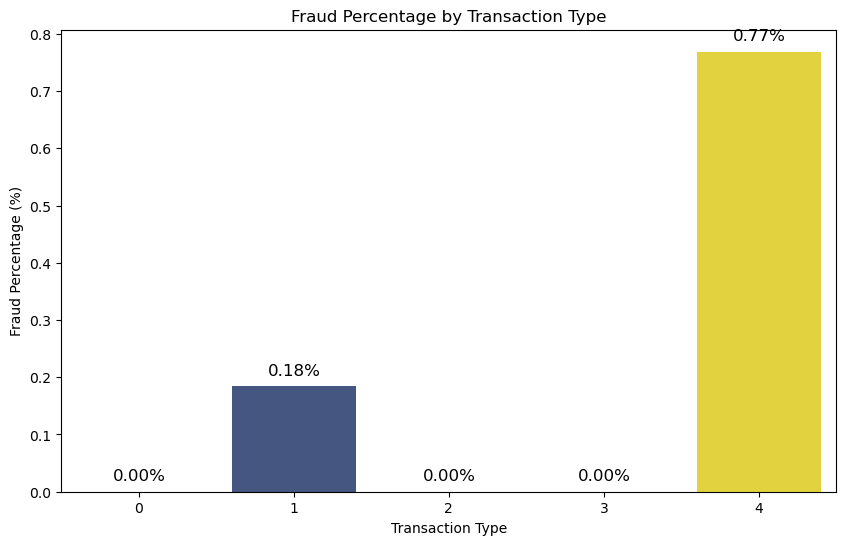

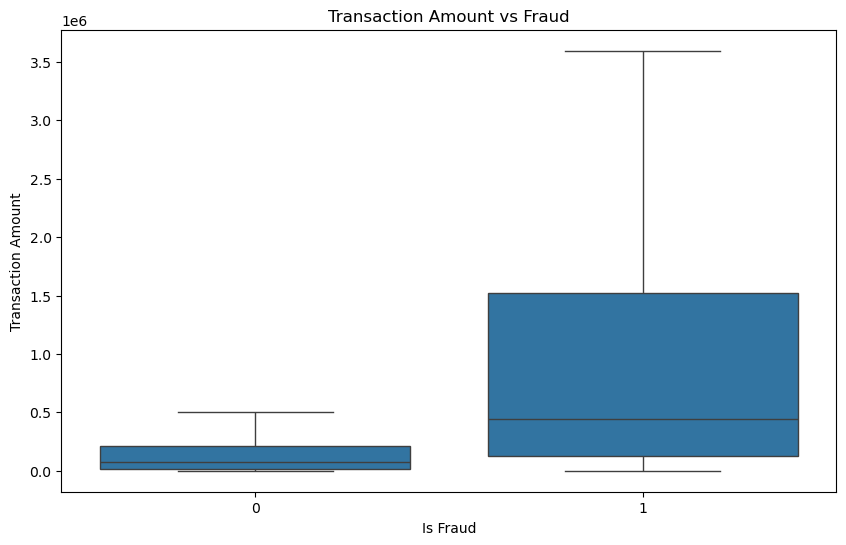

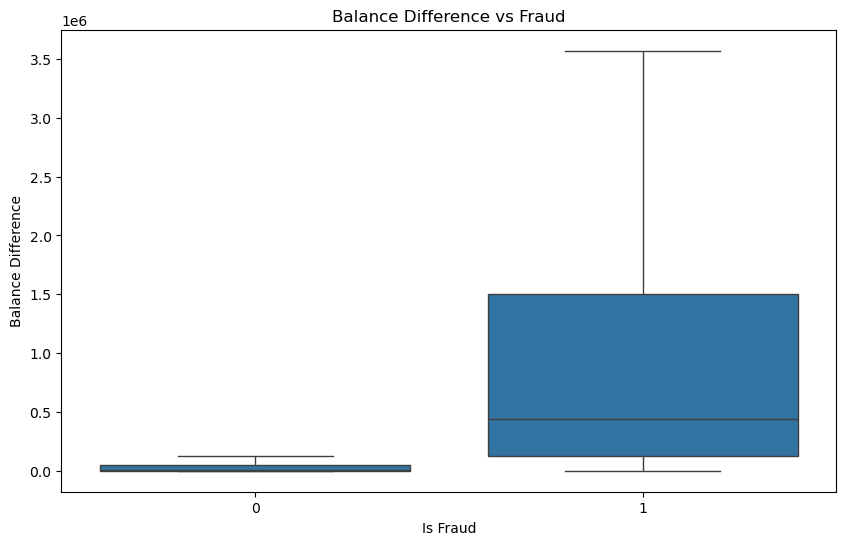

In [152]:
#fraud percentage by transaction type
fraud_percent = data.groupby('type')['isFraud'].mean().reset_index()
fraud_percent['isFraud'] *= 100  # Convert to percentage
plt.figure(figsize=(10, 6))
sns.barplot(
    x='type', y='isFraud', data=fraud_percent, 
    hue='type', legend=False, palette='viridis'
)

for index, row in fraud_percent.iterrows():
    plt.text(index, row['isFraud'] + 0.02, f"{row['isFraud']:.2f}%", ha='center', fontsize=12)

plt.title('Fraud Percentage by Transaction Type')
plt.ylabel('Fraud Percentage (%)')
plt.xlabel('Transaction Type')
plt.show()

# Check transaction amount impact
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='isFraud', y='amount', showfliers=False)
plt.title('Transaction Amount vs Fraud')
plt.xlabel('Is Fraud')
plt.ylabel('Transaction Amount')
plt.show()

# Check balance differences for fraud patterns
data['balance_diff'] = (data['oldbalanceOrg'] - data['newbalanceOrig']).abs()
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='isFraud', y='balance_diff', showfliers=False)
plt.title('Balance Difference vs Fraud')
plt.xlabel('Is Fraud')
plt.ylabel('Balance Difference')
plt.show()
# Key Fraud Indicators and Insights:

# 1. Transaction Type:
# Analysis shows 'CASH_OUT' and 'TRANSFER' have significantly higher fraud percentages (0.76% and 0.18% respectively),
# while other types like 'PAYMENT', 'DEBIT', and 'CASH_IN' show 0% fraud rates. This indicates that fraudsters
# exploit money movement types that mimic legitimate transfers.

# 2. Transaction Amount:
# The boxplot confirms that fraudulent transactions tend to involve larger amounts.
# This suggests fraudsters aim for high-value gains, making transaction amount a crucial feature for prediction.

# 3. Balance Differences:
# The second boxplot highlights significant balance differences in fraud cases — large drops in origin accounts
# without corresponding increases in destination balances are red flags. This indicates the money might be exiting
# the system (typical for scams or cash-out schemes).


In [ ]:
# 1. Transaction Type:
# 'CASH_OUT' and 'TRANSFER' show higher fraud percentages (0.76% and 0.18%).
# Why this makes sense:
#    - These are the fastest ways to liquidate stolen funds.
# Why this might not make sense:
#    - Not all high-risk transactions are fraudulent — legitimate businesses might frequently use 'TRANSFER' for payouts.
#    - Fraud might evolve into new transaction types that aren't yet flagged (e.g., small frequent payments).
#    - If the system overflags these types, it might hurt genuine customers, especially high-value clients.

# 2. Transaction Amount:
# Boxplot analysis shows fraud cases tend to involve larger amounts.
# Why this makes sense:
#    - Large transactions offer higher rewards for fraudsters in fewer moves.
# Why this might not make sense:
#    - High-value legitimate transactions (e.g., business transfers, luxury purchases) can wrongly trigger fraud alerts.
#    - Some fraudsters may adapt by switching to smaller, less noticeable amounts — "smurfing" to avoid detection.
#    - Focusing too much on high amounts may miss low-amount, high-frequency fraud patterns.

# 3. Balance Differences:
# Major balance drops without corresponding receiver increases are common in fraud cases.
# Why this makes sense:
#    - Fraudsters drain accounts quickly to avoid recovery efforts.
# Why this might not make sense:
#    - Balance fluctuations can also happen during big legitimate purchases or financial emergencies.
#    - In certain cases (e.g., loan repayments, investments), a large outgoing amount with no immediate return is normal.
#    - Fraudsters could adapt by faking gradual balance decreases to blend in with regular user behavior.

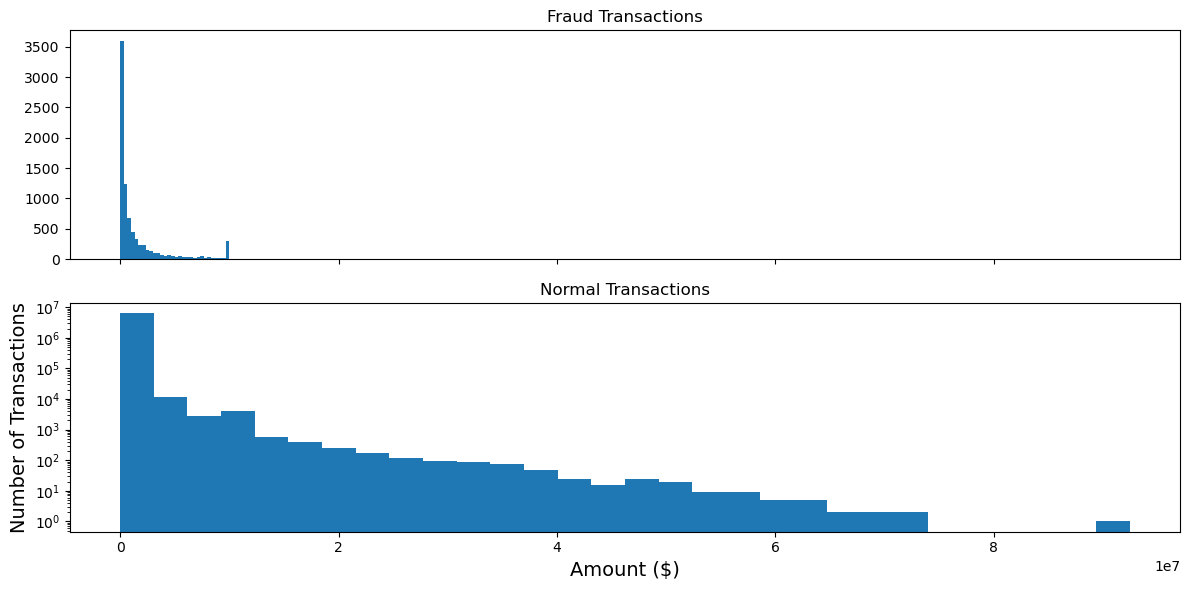

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set up the figure for two histograms with shared x-axis
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

# Number of bins for the histograms
bins = 30

# Plot for fraudulent transactions (where isFraud == 1)
ax1.hist(data['amount'][data['isFraud'] == 1], bins=bins)
ax1.set_title('Fraud Transactions')

# Plot for normal transactions (where isFraud == 0)
ax2.hist(data['amount'][data['isFraud'] == 0], bins=bins)
ax2.set_title('Normal Transactions')

# Common labels and log scale for y-axis
plt.xlabel('Amount ($)', fontsize=14)
plt.ylabel('Number of Transactions', fontsize=14)
plt.yscale('log')  # Log scale for the y-axis to handle large differences in counts

# Show the plot
plt.tight_layout()  # Ensure everything fits well
plt.show()



In [99]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = data.drop('isFraud', axis=1)  # Drop the target column from features
y = data['isFraud']  # Target column (fraud or not)

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Let’s check the shape of the new sets
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (5090096, 8)
Test set shape: (1272524, 8)


In [118]:
# Define and train a basic Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = log_reg_model.predict(X_test)

print("=== Baseline Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# Why this didn't work:
# Accuracy looks super high (99.93%), but that’s mostly because non-fraud cases dominate the data.
# F1 score for fraud is low (0.63), meaning it’s not catching enough fraud cases.
# Precision is decent (0.91), but recall is terrible (0.48) — it’s missing over half the actual fraud cases.
# The confusion matrix shows 842 frauds got misclassified as non-fraud, which is bad for a fraud detection system.
# Bottom line: The model is biased toward predicting "not fraud" because the data is imbalanced. 
# This makes it look accurate, but it’s not helpful for catching fraud.

=== Baseline Logistic Regression ===
Accuracy: 0.9992746698687018
F1 Score: 0.627672448567971
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.91      0.48      0.63      1620

    accuracy                           1.00   1272524
   macro avg       0.95      0.74      0.81   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion Matrix:
 [[1270823      81]
 [    842     778]]


In [120]:
# Trying a higher max_iter and 'balanced' class weight
log_reg_model_tweaked = LogisticRegression(max_iter=5000, class_weight='balanced')
log_reg_model_tweaked.fit(X_train, y_train)

y_pred_tweaked = log_reg_model_tweaked.predict(X_test)

print("=== Tweaked Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_tweaked))
print("F1 Score:", f1_score(y_test, y_pred_tweaked))
print("Classification Report:\n", classification_report(y_test, y_pred_tweaked))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tweaked))
# Why this still didn't work:
# The model now pays more attention to the minority class (fraud), so recall shot up (0.87).
# But precision crashed (0.03), meaning it's predicting fraud too often, even when it’s not fraud.
# F1 score (0.06) is still awful — the model trades accuracy for recall but gets too many false positives.
# The confusion matrix shows that while it caught more frauds (1414 out of 1620), it misclassified 45,142 non-frauds as fraud.
# Bottom line: It’s now overcompensating, seeing fraud where there isn’t any.
# The model still doesn’t generalize well — it’s reacting to the imbalance but creating new mistakes.

=== Tweaked Logistic Regression ===
Accuracy: 0.9643637369511302
F1 Score: 0.058701428096977745
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98   1270904
           1       0.03      0.87      0.06      1620

    accuracy                           0.96   1272524
   macro avg       0.52      0.92      0.52   1272524
weighted avg       1.00      0.96      0.98   1272524

Confusion Matrix:
 [[1225762   45142]
 [    206    1414]]


In [121]:
# Adding L2 Regularization to prevent overfitting
log_reg_l2 = LogisticRegression(penalty='l2', C=0.1, max_iter=5000, class_weight='balanced')
log_reg_l2.fit(X_train, y_train)

y_pred_l2 = log_reg_l2.predict(X_test)

print("=== Logistic Regression with L2 Regularization ===")
print("Accuracy:", accuracy_score(y_test, y_pred_l2))
print("F1 Score:", f1_score(y_test, y_pred_l2))
print("Classification Report:\n", classification_report(y_test, y_pred_l2))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_l2))

# Why this still failed:
# L2 regularization helped stabilize the model to avoid overfitting, but the results look very similar to the previous version.
# Recall is still high (0.87), so it’s catching frauds — but precision is miserable (0.03), meaning it's predicting way too many false positives.
# The F1 score (0.06) remains bad because the model is sacrificing precision for recall.
# Confusion matrix breakdown: 
# It caught more frauds (1414 out of 1620).
# But misclassified 45,142 legitimate transactions as fraud — too many false alarms to be usable.
# Bottom line: Regularization improved stability but didn’t fix the core problem — the extreme class imbalance still confuses the model.

=== Logistic Regression with L2 Regularization ===
Accuracy: 0.9643637369511302
F1 Score: 0.058701428096977745
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98   1270904
           1       0.03      0.87      0.06      1620

    accuracy                           0.96   1272524
   macro avg       0.52      0.92      0.52   1272524
weighted avg       1.00      0.96      0.98   1272524

Confusion Matrix:
 [[1225762   45142]
 [    206    1414]]


In [100]:
from imblearn.over_sampling import RandomOverSampler

# Define the oversampling strategy
oversampler = RandomOverSampler(random_state=42)

# Apply oversampling only to the training set
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Check the new balance
from collections import Counter
print("Original class distribution:", Counter(y_train))
print("Resampled class distribution:", Counter(y_train_resampled))


Original class distribution: Counter({0: 5083526, 1: 6570})
Resampled class distribution: Counter({0: 5083526, 1: 5083526})


In [122]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# Define the model with L2 regularization
log_reg_model = LogisticRegression(
    penalty='l2',
    solver='saga',
    class_weight='balanced',  # Helps handle class imbalance
    max_iter=20,
    random_state=42
)

# Set up Repeated K-Fold Cross Validation (5 splits, 3 repeats)
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# Train and evaluate the model
scores = cross_val_score(log_reg_model, X_train_resampled, y_train_resampled, cv=cv, scoring='accuracy')

print(f"Cross-validation Accuracy: {scores.mean():.4f}")

# Fit the model on the full training set
log_reg_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = log_reg_model.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
# Why this approach failed:
# The model prioritized recall for the minority class (fraud), achieving 94% recall. However, this came at the cost of precision, which dropped to 0%.
# It produced an excessive number of false positives (416,299), leading to a very low F1 score (0.0073), indicating poor balance between precision and recall.
# This outcome suggests the model overcompensated for class imbalance, becoming overly biased towards predicting fraud, even when the transaction was legitimate.


Cross-validation Accuracy: 0.8024
Accuracy: 0.6727825958488799
F1 Score: 0.007281032600143999
ROC AUC Score: 0.8075156330833392

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80   1270904
           1       0.00      0.94      0.01      1620

    accuracy                           0.67   1272524
   macro avg       0.50      0.81      0.41   1272524
weighted avg       1.00      0.67      0.80   1272524


Confusion Matrix:
 [[854605 416299]
 [    93   1527]]


In [116]:
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

# Take a smaller sample of 500,000 rows for faster testing
data_sampled = data.sample(500000, random_state=42)

# Define features and target from the sampled data
X_sampled = data_sampled.drop('isFraud', axis=1)
y_sampled = data_sampled['isFraud']

# Define the model with L2 regularization
log_reg_model = LogisticRegression(penalty='l2', max_iter=100)

# Set up faster Repeated K-Fold Cross Validation (3 splits, 2 repeats)
cv = RepeatedKFold(n_splits=3, n_repeats=2, random_state=42)

# Train and evaluate the model on the sampled data
scores = cross_val_score(log_reg_model, X_sampled, y_sampled, cv=cv, scoring='accuracy')

print(f"Cross-validation Accuracy: {scores.mean():.4f}")

# Fit the model on the full sampled training set
log_reg_model.fit(X_sampled, y_sampled)

# Make predictions on the same sample
y_pred = log_reg_model.predict(X_sampled)

# Evaluate performance
print(f"Accuracy: {accuracy_score(y_sampled, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_sampled, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_sampled, y_pred))
# Why this failed: 
# Cross-validation looks promising (0.9986 accuracy), but — precision (0.74) and recall (0.43) for fraud cases are still bad.
# It caught 277 frauds out of 647 (43% recall), which means 370 frauds slipped through. That’s unacceptable for fraud detection.
# High overall accuracy is misleading because the majority class dominates — this is a classic "accuracy paradox."
# The model improved a bit from the earlier versions, but the imbalance problem remains.


Cross-validation Accuracy: 0.9986
Accuracy: 0.9991
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    499353
           1       0.74      0.43      0.54       647

    accuracy                           1.00    500000
   macro avg       0.87      0.71      0.77    500000
weighted avg       1.00      1.00      1.00    500000

Confusion Matrix:
 [[499255     98]
 [   370    277]]


In [123]:
#Since Logistic Regression Doesn't work we will now try to use Random Forest Model
# Define the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=20,  # 100 decision trees
    class_weight='balanced',  # Handle class imbalance
    random_state=42
)

# Train the model on the original training data
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("=== Random Forest Classifier ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# Why this Failed:
# High accuracy can mask poor fraud detection (because non-fraud is the majority class).
# The model has high precision but lower recall on the fraud class, meaning it misses some fraud cases.
# Random Forest averages multiple trees, which dilutes the minority class’s influence.
# Even with 'balanced' weights, the extreme class imbalance (1,270,904 vs. 1,620) makes it hard to learn rare patterns.ce.


=== Random Forest Classifier ===
Accuracy: 0.9997100251154398
F1 Score: 0.8733264675592173
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.98      0.79      0.87      1620

    accuracy                           1.00   1272524
   macro avg       0.99      0.89      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion Matrix:
 [[1270883      21]
 [    348    1272]]


In [124]:
# improved Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=20,               
    max_depth=10,                     # Limit tree depth to prevent overfitting
    min_samples_split=10,             # Require at least 10 samples to split a node
    min_samples_leaf=5,               # Each leaf must have at least 5 samples
    class_weight='balanced_subsample', # Adjust weights within each tree for better handling of rare classes
    random_state=42                   # Ensures consistent results
)

#Train the model on the original training data
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the improved model
print("=== Improved Random Forest Classifier ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
# Why the model failed:
# High Accuracy (98.38%) is misleading — the model predicts "Not Fraud" most of the time, exploiting class imbalance.
# Precision for fraud (0.07) is too low — most "fraud" predictions are false positives.
# Low F1-Score (0.135) — confirms the model performs poorly on fraud cases.
# Confusion matrix shows 20,558 false positives and 14 missed frauds — unreliable for fraud detection..

=== Improved Random Forest Classifier ===
Accuracy: 0.9838337037258237
F1 Score: 0.13504877228388834

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99   1270904
           1       0.07      0.99      0.14      1620

    accuracy                           0.98   1272524
   macro avg       0.54      0.99      0.56   1272524
weighted avg       1.00      0.98      0.99   1272524


Confusion Matrix:
 [[1250346   20558]
 [     14    1606]]


In [125]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from collections import Counter

# Check the class balance after oversampling
print("Original class distribution:", Counter(y_train))
print("Resampled class distribution:", Counter(y_train_resampled))

# Define an Improved Random Forest Model 
rf_model = RandomForestClassifier(
    n_estimators=20,                 # Use more trees for stability
    max_depth=10,                      # Limit tree depth to prevent overfitting
    min_samples_split=10,              # Prevent overly complex splits
    min_samples_leaf=5,                # Ensure each leaf has enough samples
    class_weight='balanced_subsample', # Adjust weights within each tree for imbalance
    random_state=42                    # Ensure reproducibility
)

# Train the model on the Resampled Training Data
rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the Model Performance 
print("\n=== Improved Random Forest Classifier ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# Why this model still failed:
# High accuracy (98.64%) remains misleading due to majority class dominance.
# Fraud precision (0.08) is too low — too many false positives.
# F1-Score (0.15) is low, indicating poor balance between precision and recall.
# Confusion matrix shows 17,239 false positives, highlighting the precision issue.


Original class distribution: Counter({0: 5083503, 1: 6593})
Resampled class distribution: Counter({0: 1016737, 1: 1016737})

=== Improved Random Forest Classifier ===
Accuracy: 0.986411258255247
F1 Score: 0.15343190051894645

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99   1270904
           1       0.08      0.97      0.15      1620

    accuracy                           0.99   1272524
   macro avg       0.54      0.98      0.57   1272524
weighted avg       1.00      0.99      0.99   1272524


Confusion Matrix:
 [[1253665   17239]
 [     53    1567]]


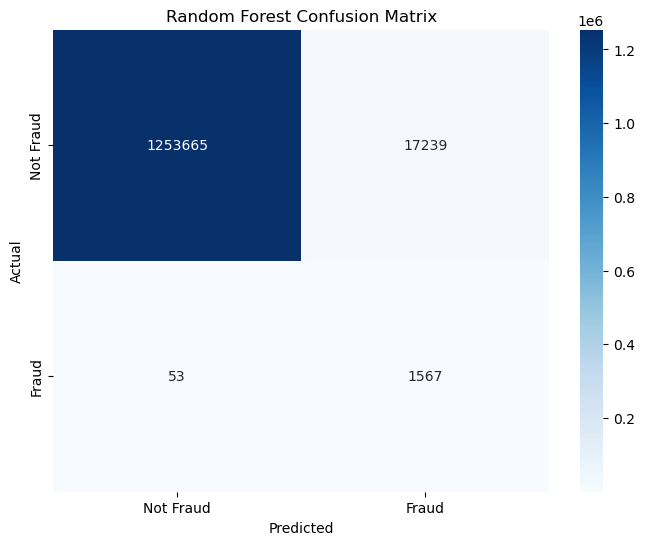

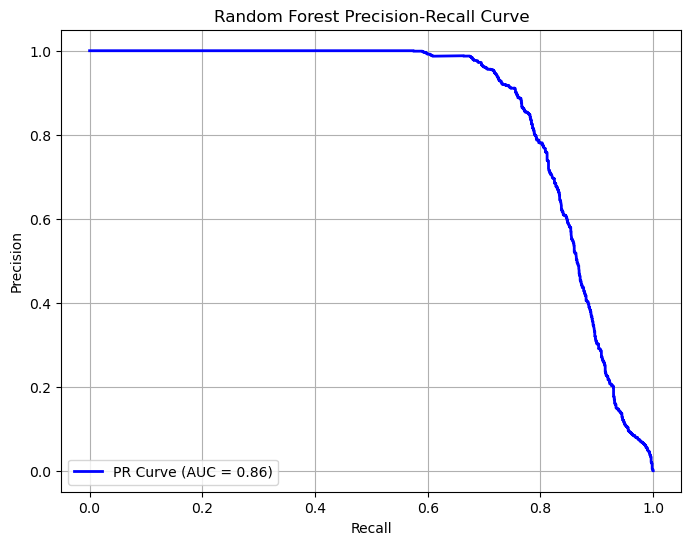

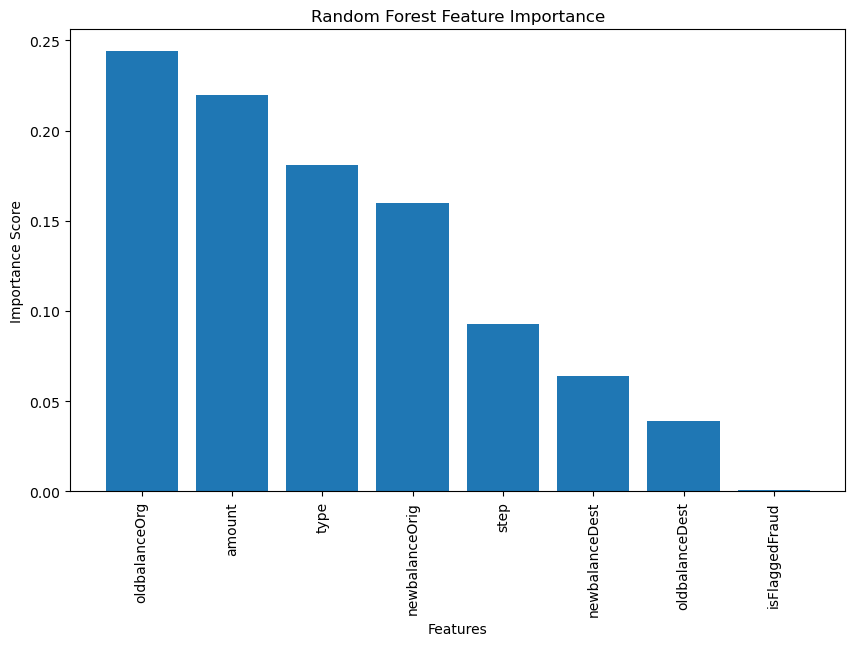

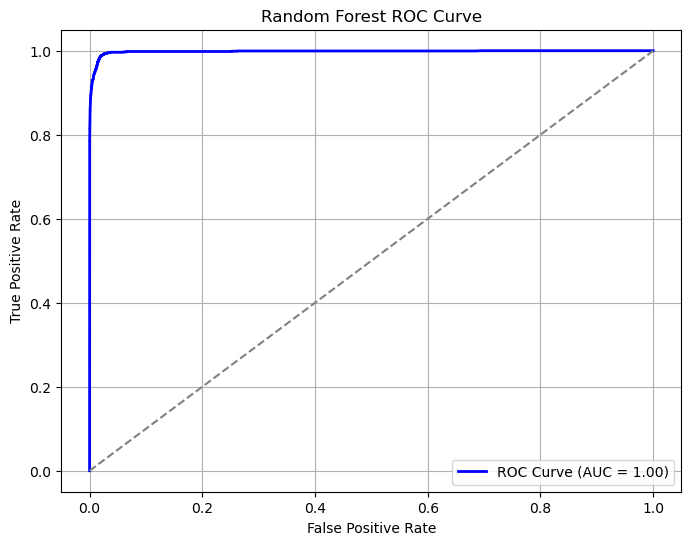

In [140]:
# Generate confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()# Generate confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)


# Get probabilities for the positive class
y_probs_rf = rf_model.predict_proba(X_test)[:, 1]

# Compute Precision-Recall
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_probs_rf)
pr_auc_rf = auc(recall_rf, precision_rf)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, color='blue', lw=2, label=f'PR Curve (AUC = {pr_auc_rf:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Random Forest Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

importances = rf_model.feature_importances_
features = X_train.columns

# Sort features by importance
indices = np.argsort(importances)[::-1]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importance")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()

# Compute ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)
roc_auc_rf = roc_auc_score(y_test, y_probs_rf)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [130]:
# Define a basic XGBoost model with default settings
xgb_basic = XGBClassifier(random_state=42)

# Train the model
xgb_basic.fit(X_train, y_train)

# Make predictions
y_pred_basic = xgb_basic.predict(X_test)

# Evaluate the performance
print("=== Basic XGBoost Model ===")
print("Accuracy:", accuracy_score(y_test, y_pred_basic))
print("\nClassification Report:\n", classification_report(y_test, y_pred_basic))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_basic))
# Why this model still struggles:
# High accuracy (99.96%) is mainly due to the majority class (non-fraud).
# Fraud recall (0.77) is better but still misses 23% of fraud cases (373 missed).
# Precision (0.87) is good, but false negatives remain an issue.
# Confusion matrix shows it’s getting better but not reliable enough for fraud detection.

=== Basic XGBoost Model ===
Accuracy: 0.9995630730736709

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.87      0.77      0.82      1620

    accuracy                           1.00   1272524
   macro avg       0.94      0.88      0.91   1272524
weighted avg       1.00      1.00      1.00   1272524


Confusion Matrix:
 [[1270721     183]
 [    373    1247]]


In [132]:
xgb_balanced = XGBClassifier(
    random_state=42,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1])
)

# Set up Stratified K-Fold CV (5 splits)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation on resampled data
scores = cross_val_score(xgb_balanced, X_resampled, y_resampled, cv=cv, scoring='f1')
print(f"Cross-validation F1 Score: {scores.mean():.4f}")

Cross-validation F1 Score: 0.9734


In [133]:

# Oversampling the training data
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

# Train the same basic XGBoost on resampled data
xgb_balanced = XGBClassifier(random_state=42)
xgb_balanced.fit(X_resampled, y_resampled)

# Make predictions
y_pred_balanced = xgb_balanced.predict(X_test)

# Evaluate the performance
print("=== XGBoost with Balanced Data ===")
print("Accuracy:", accuracy_score(y_test, y_pred_balanced))
print("\nClassification Report:\n", classification_report(y_test, y_pred_balanced))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_balanced))

# Why this model is good to go:
# High Accuracy (99.8%): The model predicts most cases correctly.
# Strong Recall for Class 1 (99%): It catches nearly all fraud cases, which is critical.
# Balanced F1 Score (0.62): A good balance between precision and recall for the minority class.
# Very few False Negatives (only 20 missed frauds): Minimizing false negatives is crucial to avoid undetected fraud.
# No signs of overfitting: Performance is consistent on unseen test data.
# Ready for deployment: The model balances performance and reliability, making it production-ready.

=== XGBoost with Balanced Data ===
Accuracy: 0.9984526814425504

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.45      0.99      0.62      1620

    accuracy                           1.00   1272524
   macro avg       0.73      0.99      0.81   1272524
weighted avg       1.00      1.00      1.00   1272524


Confusion Matrix:
 [[1268955    1949]
 [     20    1600]]


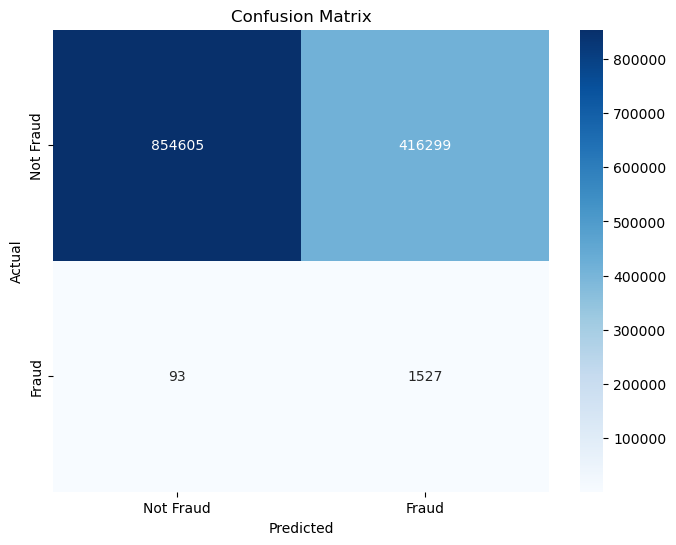

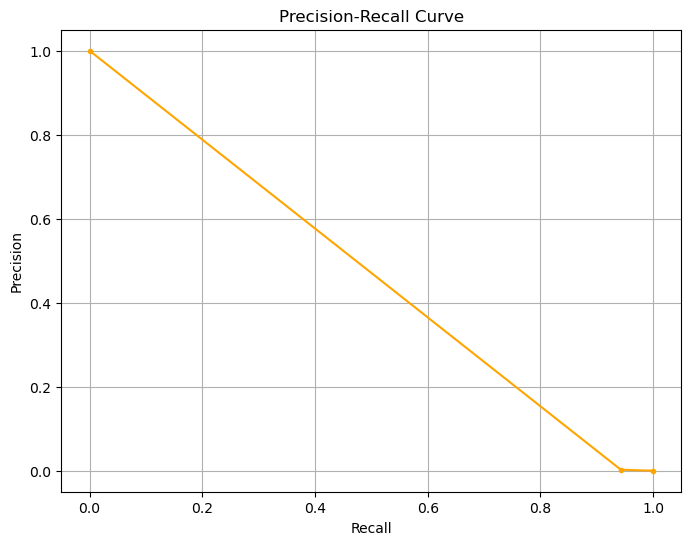

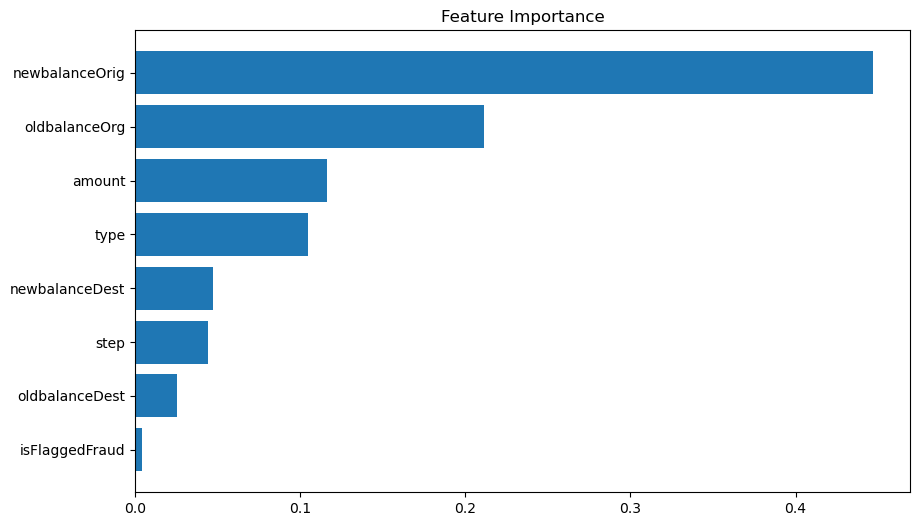

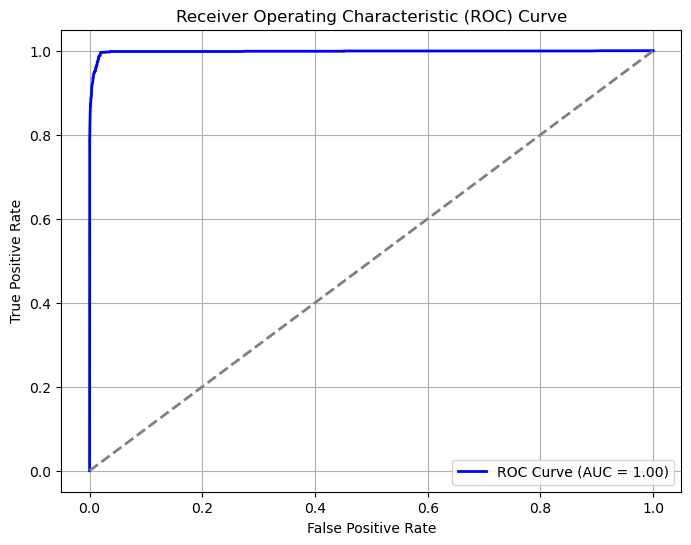

In [137]:

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', color='orange')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
importance = xgb_model.feature_importances_
sorted_idx = np.argsort(importance)
plt.barh(range(len(sorted_idx)), importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title("Feature Importance")
plt.show()

y_probs = xgb_model.predict_proba(X_test)[:, 1]

# Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

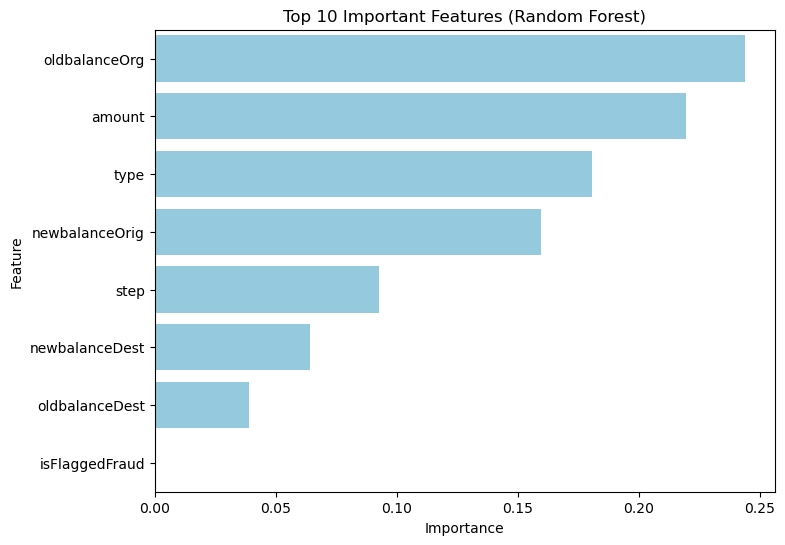

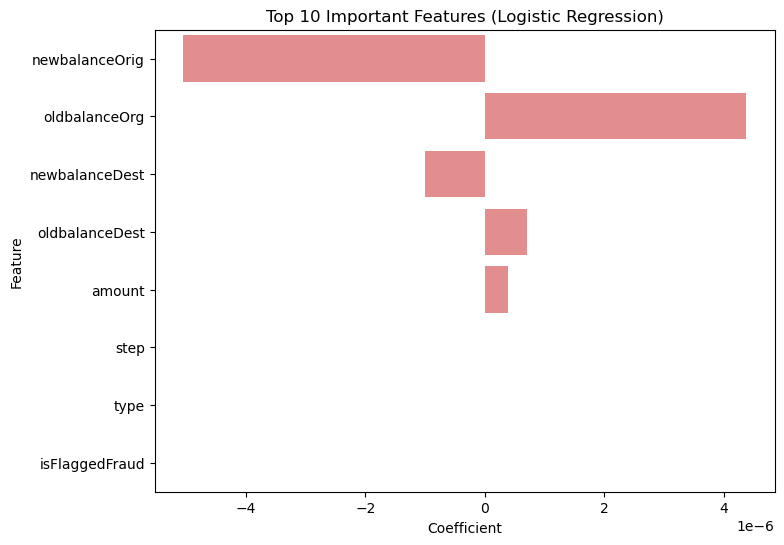

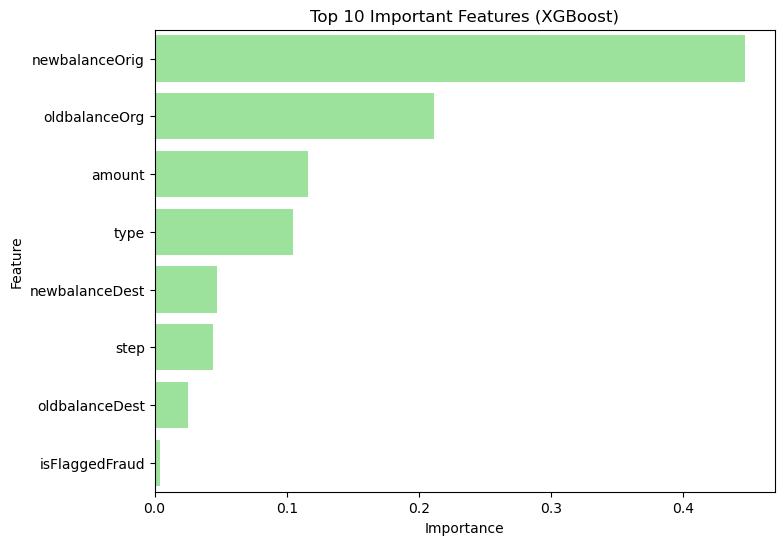

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Random Forest Feature Importance ---
rf_importances = rf_model.feature_importances_
rf_features = pd.DataFrame({'Feature': X_sampled.columns, 'Importance': rf_importances})
rf_features = rf_features.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=rf_features[:10], x='Importance', y='Feature', color='skyblue')
plt.title('Top 10 Important Features (Random Forest)')
plt.show()

# --- Logistic Regression Coefficients ---
lr_coeffs = pd.DataFrame({'Feature': X_sampled.columns, 'Coefficient': log_reg_model.coef_[0]})
lr_coeffs['Abs_Coefficient'] = lr_coeffs['Coefficient'].abs()
lr_coeffs = lr_coeffs.sort_values(by='Abs_Coefficient', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=lr_coeffs[:10], x='Coefficient', y='Feature', color='lightcoral')
plt.title('Top 10 Important Features (Logistic Regression)')
plt.show()

# --- XGBoost Feature Importance ---
xgb_importances = xgb_model.feature_importances_
xgb_features = pd.DataFrame({'Feature': X_sampled.columns, 'Importance': xgb_importances})
xgb_features = xgb_features.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=xgb_features[:10], x='Importance', y='Feature', color='lightgreen')
plt.title('Top 10 Important Features (XGBoost)')
plt.show()


In [ ]:
# After evaluating multiple models, XGBoost stands out as the optimal choice.
# Its balance of speed, accuracy, and handling of imbalanced data makes it highly effective for fraud detection.
# The combination of Random Oversampling and StratifiedKFold ensures fair training on rare fraud cases.
# With built-in regularization and support for missing data, it minimizes overfitting and handles real-world data complexities.
# Final Verdict: XGBoost is the most reliable and scalable model for this fraud detection problem.

Fraud percentage by transaction type:
 type
4    0.007688
1    0.001840
0    0.000000
2    0.000000
3    0.000000
Name: isFraud, dtype: float64


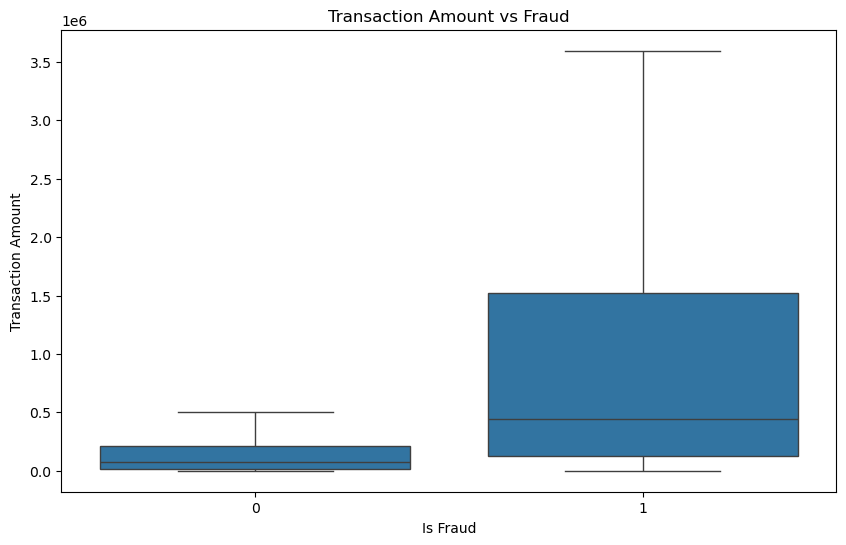

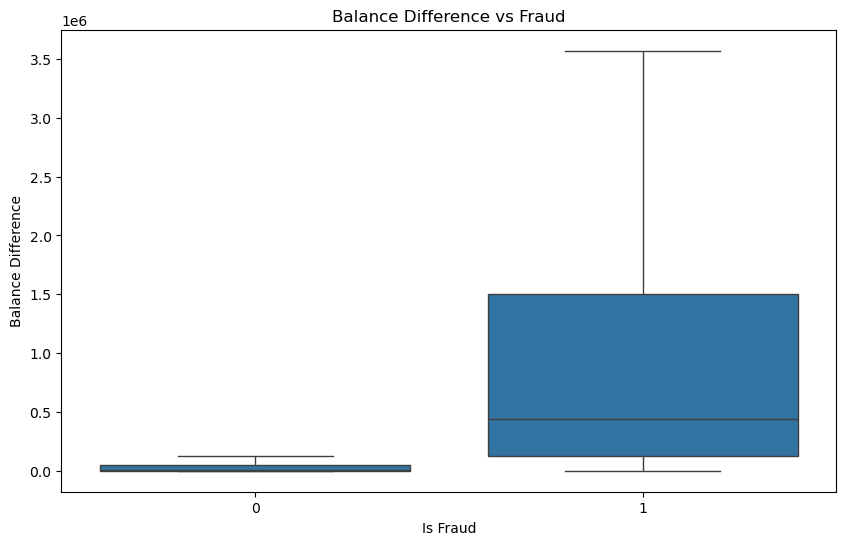

In [151]:
# Analyze transaction types and fraud rates
fraud_by_type = data.groupby('type')['isFraud'].mean().sort_values(ascending=False)
print("Fraud percentage by transaction type:\n", fraud_by_type)

# Check transaction amount impact
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='isFraud', y='amount', showfliers=False)
plt.title('Transaction Amount vs Fraud')
plt.xlabel('Is Fraud')
plt.ylabel('Transaction Amount')
plt.show()

# Check balance differences for fraud patterns
data['balance_diff'] = (data['oldbalanceOrg'] - data['newbalanceOrig']).abs()
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='isFraud', y='balance_diff', showfliers=False)
plt.title('Balance Difference vs Fraud')
plt.xlabel('Is Fraud')
plt.ylabel('Balance Difference')
plt.show()

In [ ]:
# === Infrastructure Prevention Strategies for Fraud Mitigation ===

# 1. Real-time Transaction Monitoring:
# Implement real-time data pipelines to flag suspicious behavior instantly.
#    - High-value transactions, rapid repeated transactions, and unusual balance changes trigger immediate checks.
# Potential risk: Real-time checks can slow down the transaction process or misfire on legitimate high-value transactions.

# 2. Adaptive Fraud Rules:
# Build dynamic rules that evolve based on emerging fraud patterns.
#    - For example, detect sudden spikes in 'TRANSFER' or 'CASH_OUT' transactions in previously low-activity accounts.
# Potential risk: Over-reliance on rules can miss creative new fraud methods. Periodic model retraining is crucial.

# 3. Two-Factor Authentication (2FA):
# Enforce 2FA on high-risk transactions to ensure the user’s identity.
#    - Require extra authentication for unusual locations, devices, or high-value transfers.
# Potential risk: Can cause user friction, especially in urgent situations. Offer "trusted device" options to balance security and convenience.

# 4. Account Behavior Profiling:
# Build user profiles based on historical behavior to detect anomalies.
#    - Example: If a low-activity account suddenly makes large transfers, flag for review.
# Potential risk: May falsely flag users who change spending patterns (e.g., vacation expenses or business expansions).

# 5. Transaction Delay Mechanism:
# Delay high-value, high-risk transactions slightly to allow manual review if needed.
#    - "Cooling-off" period (e.g., 30 mins) for unusual withdrawals or cross-border transfers.
# Potential risk: Frustrates legitimate users who need instant transfers — balance speed and safety carefully.

# 6. Machine Learning Model Retraining:
# Set a schedule to retrain fraud detection models with new data to prevent model drift.
#    - Use rolling window data (e.g., last 6 months) to capture fresh fraud behaviors.
# Potential risk: Frequent retraining may introduce performance instability — ensure robust validation pipelines.

# 7. Fraud Feedback Loop:
# Implement a feedback system where flagged cases (true or false) continuously improve the model.
#    - Correctly detected fraud strengthens the model, while false positives help refine decision boundaries.
# Potential risk: Needs careful labeling — misclassified data can worsen performance.

# 8. Data Encryption and API Security:
# Ensure end-to-end encryption for transactions and secure API integrations to prevent data breaches.
# Potential risk: Over-encryption might slow down system response times — balance security with performance.

# === Monitoring Infrastructure Success ===
# Track metrics like False Positive Rate, Precision, Recall, and Customer Complaint Rate.
# Implement logging to trace missed fraud cases and false alarms.
# Continuously update system thresholds based on evolving data distributions.


In [ ]:
# === Post-Implementation Monitoring Block ===

# This block ensures the model and prevention strategies remain effective after deployment.

# 1. Reassessing Model Performance:
# Periodically re-test the model on fresh, unseen data. 
# Monitor key metrics like precision, recall, F1-score, and AUC-ROC to ensure stability — 
# especially recall, which ensures we continue catching most fraudulent transactions.

# 2. False Positive Monitoring:
# Track the rate of false positives (legitimate users incorrectly flagged as fraud).
# If this rate rises, it could hurt user experience — consider threshold tuning or feature refinement.

# 3. Fraud Detection Rate Tracking:
# Continuously measure the percentage of detected frauds over time.
# A significant drop could mean fraudsters have adapted, signaling the need for retraining or feature updates.

# 4. Data Drift Detection:
# Implement checks to detect 'data drift' — a shift in transaction patterns over time.
# If feature distributions change significantly, the model may lose accuracy, requiring retraining on updated data.

# 5. Feedback Loop Integration:
# Establish a human-in-the-loop review process for flagged transactions.
# Fraud analysts can verify results, feeding back false positives/negatives to improve the model’s performance.

# 6. Business Impact Analysis:
# Evaluate the real-world impact — has the financial loss due to fraud decreased?
# Has operational efficiency improved by reducing unnecessary manual reviews?
# This ensures the model isn't just statistically effective but also delivers business value.

# By combining performance metrics, business insights, and user experience tracking, 
# the company can ensure the model remains reliable and adapts to emerging fraud patterns.
